In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve


import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
os.getcwd()

'/home/xyy/jupyter/code'

In [54]:
dir='/home/xyy/jupyter/train_data'
X=pd.read_excel(os.path.join(dir,"Intergrate_train.xlsx"))
y=pd.read_excel(os.path.join(dir,"y_train.xlsx"))
X=X.iloc[:,1:]
y=y.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train= X_train.reset_index()
X_train=X_train.iloc[:,1:]

X_test= X_test.reset_index()
X_test=X_test.iloc[:,1:]

y_train=y_train.reset_index()
y_train=y_train.iloc[:,1:]

y_test= y_test.reset_index()
y_test=y_test.iloc[:,1:]

In [107]:
# 定义模型和调优空间
models = {
    "Logit": LogisticRegression,
    "RF": RandomForestClassifier,
    "SVM": SVC,
    "XGBoost": XGBClassifier,
    "KNN":KNeighborsClassifier,
    "AB":AdaBoostClassifier,
    'GNB':GaussianNB,
    'DT':DecisionTreeClassifier
    # 其他模型可以在此添加
}

def objective(trial, model_class):
    if model_class == LogisticRegression:
        params = {
            "C": trial.suggest_loguniform("C", 1e-5, 1e2),
            "max_iter": trial.suggest_int("max_iter", 100, 1000)
        }
    elif model_class == RandomForestClassifier:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 200),
            "max_depth": trial.suggest_int("max_depth", 2, 32)
        }
    elif model_class == SVC:
        params = {
            "C": trial.suggest_loguniform("C", 1e-5, 1e2),
            "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
            "probability":trial.suggest_categorical("probability", [True])
        }
    elif model_class == XGBClassifier:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 200),
            "max_depth": trial.suggest_int("max_depth", 2, 32),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1.0)
        }
    elif model_class==KNeighborsClassifier:
        params={
            "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "p": trial.suggest_int("p", 1, 2)
        }
    elif model_class==AdaBoostClassifier:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 400),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1),
            "algorithm": trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
        }
    elif model_class== GaussianNB:
        params={}
    elif model_class==DecisionTreeClassifier:
        params = {
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth": trial.suggest_int("max_depth", 1, 32),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5)
        }
        
        
    # elif model_class == LGBMClassifier:
    #     params = {
    #         "n_estimators": trial.suggest_int("n_estimators", 10, 200),
    #         "max_depth": trial.suggest_int("max_depth", 2, 32),
    #         "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1.0)
    #     }

    model = model_class(**params)
    score = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score)).mean()
    return score


In [108]:
optimized_models = {}
for name, model_class in models.items():
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_class), n_trials=50)
    optimized_models[name] = model_class(**study.best_params)

    print(f"Best parameters for {name}: {study.best_params}")

[I 2024-07-04 16:20:30,515] A new study created in memory with name: no-name-83511273-483b-458e-bee1-76d4234d5adf
/tmp/ipykernel_132748/2483458735.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-5, 1e2),
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sk

Best parameters for Logit: {'C': 0.2268442498573898, 'max_iter': 615}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[I 2024-07-04 16:20:32,931] Trial 0 finished with value: 0.6857683982683984 and parameters: {'n_estimators': 158, '

Best parameters for RF: {'n_estimators': 92, 'max_depth': 15}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Best parameters for SVM: {'C': 31.656875899587238, 'kernel': 'sigmoid', 'probability': True}


[I 2024-07-04 16:20:52,279] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 192, 'max_depth': 28, 'learning_rate': 0.00026343324047397427}. Best is trial 0 with value: 0.5.
/tmp/ipykernel_132748/2483458735.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1.0)
[I 2024-07-04 16:20:52,590] Trial 1 finished with value: 0.5623917748917749 and parameters: {'n_estimators': 18, 'max_depth': 13, 'learning_rate': 0.050456603567694394}. Best is trial 1 with value: 0.5623917748917749.
/tmp/ipykernel_132748/2483458735.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.sugg

Best parameters for XGBoost: {'n_estimators': 117, 'max_depth': 2, 'learning_rate': 0.050714669479119394}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

Best parameters for KNN: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Best parameters for AB: {'n_estimators': 384, 'learning_rate': 0.008817175309666983, 'algorithm': 'SAMME.R'}


[I 2024-07-04 16:22:30,721] Trial 11 finished with value: 0.571590909090909 and parameters: {}. Best is trial 0 with value: 0.571590909090909.
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packa

Best parameters for GNB: {}


[I 2024-07-04 16:22:31,603] Trial 9 finished with value: 0.590422077922078 and parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.6060064935064935.
[I 2024-07-04 16:22:31,630] Trial 10 finished with value: 0.6266774891774892 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.6266774891774892.
[I 2024-07-04 16:22:31,657] Trial 11 finished with value: 0.5489177489177488 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.6266774891774892.
[I 2024-07-04 16:22:31,685] Trial 12 finished with value: 0.558495670995671 and parameters: {'criterion': 'entropy', 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.6266774891774892.
[I 2024-07-04 16:22:31,712] Trial 13 finished with value: 0.6266774891774892 and 

Best parameters for DT: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}


In [102]:
optimized_models

{'Logit': LogisticRegression(C=0.24314646990780114, max_iter=736),
 'RF': RandomForestClassifier(max_depth=6, n_estimators=28),
 'SVM': SVC(C=31.00867710232607, kernel='sigmoid', probability=True),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.022634405041022442,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=185, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 'KNN': K

In [44]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, average_precision_score
def bootstrap_ci(model, X_test, y_test, num_bootstrap=1000, alpha=0.95):
    metrics = {
        "AUC": [],
        "F1": [],
        "Precision": [],
        "Recall": [],
        "Accuracy": [],
        "Average Precision (AP)": []
    }
    n_size = len(y_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    for _ in range(num_bootstrap):
        indices = np.random.choice(range(n_size), size=n_size, replace=True)
        if len(np.unique(y_test.loc[indices])) < 2:
            continue
            
        
        auc = roc_auc_score(y_test.loc[indices], y_pred_proba[indices])
        f1 = f1_score(y_test.loc[indices], y_pred[indices])
        precision = precision_score(y_test.loc[indices], y_pred[indices])
        recall = recall_score(y_test.loc[indices], y_pred[indices])
        accuracy = accuracy_score(y_test.loc[indices], y_pred[indices])
        ap = average_precision_score(y_test.loc[indices], y_pred_proba[indices])
        
        metrics["AUC"].append(auc)
        metrics["F1"].append(f1)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["Accuracy"].append(accuracy)
        metrics["Average Precision (AP)"].append(ap)
    
    ci_results = {}
    for metric, scores in metrics.items():
        lower = np.percentile(scores, ((1.0 - alpha) / 2.0) * 100)
        upper = np.percentile(scores, (alpha + ((1.0 - alpha) / 2.0)) * 100)
        ci_results[metric] = (np.mean(scores), (lower, upper))
    
    return ci_results

def net_benefit(probabilities, y_true, threshold):
        tp = np.sum((probabilities >= threshold) & (y_true == 1))
        fp = np.sum((probabilities >= threshold) & (y_true == 0))
        fn = np.sum((probabilities < threshold) & (y_true == 1))
        tn = np.sum((probabilities < threshold) & (y_true == 0))
        
        prevalence = (tp + fn) / (tp + fp + tn + fn)
        net_benefit = tp / (tp + fp + tn + fn) - (fp / (tp + fp + tn + fn)) * (threshold / (1 - threshold))
        return net_benefit


In [55]:
'''for name, model in optimized_models.items():
    try:
        model.fit(X_train, y_train)
        results_table = bootstrap_ci(model, X_test, y_test)
        print(f"{name} Classification CI Results:")
        print(results_table)
    except Exception as e:
        print(f"Error with model {name}: {e}")'''

results_dict = {}

for name, model in optimized_models.items():
    try:
        model.fit(X_train, y_train)
        results_table = bootstrap_ci(model, X_test, y_test)
        results_dict[name] = results_table
        print(f"{name} Classification CI Results:")
        print(results_table)
    except Exception as e:
        print(f"Error with model {name}: {e}")

print(results_dict)


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logit Classification CI Results:
{'AUC': (0.9035184336346488, (0.7692307692307693, 0.9901960784313725)), 'F1': (0.8334219328717598, (0.6666666666666666, 0.9600000000000001)), 'Precision': (0.8075237293019868, (0.5789473684210527, 1.0)), 'Recall': (0.8706644492719183, (0.6837719298245618, 1.0)), 'Accuracy': (0.8269310344827586, (0.6551724137931034, 0.9655172413793104)), 'Average Precision (AP)': (0.918988319201274, (0.7668398268398271, 0.9944469696969697))}


/tmp/ipykernel_132748/3712649633.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RF Classification CI Results:
{'AUC': (0.8471373048660185, (0.6818070409982174, 0.9853046218487395)), 'F1': (0.8309953118645569, (0.6666666666666666, 0.9500000000000001)), 'Precision': (0.7167960752359543, (0.5, 0.9047619047619048)), 'Recall': (1.0, (1.0, 1.0)), 'Accuracy': (0.7951379310344828, (0.6206896551724138, 0.9310344827586207)), 'Average Precision (AP)': (0.8135190841278681, (0.5749531024531025, 0.9899874686716792))}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Classification CI Results:
{'AUC': (0.7888506797070282, (0.6140728021978025, 0.946110681114551)), 'F1': (0.787634453258601, (0.6060606060606061, 0.9268292682926829)), 'Precision': (0.7282439343450082, (0.5262531328320802, 0.9375)), 'Recall': (0.8697109443306056, (0.6666666666666666, 1.0)), 'Accuracy': (0.7621034482758621, (0.6206896551724138, 0.896551724137931)), 'Average Precision (AP)': (0.8275468291574056, (0.6482171875818618, 0.959594285270164))}
XGBoost Classification CI Results:
{'AUC': (0.8363919804929969, (0.6615421037296038, 0.9714484126984126)), 'F1': (0.8307614530156499, (0.6875000000000001, 0.9473684210526316)), 'Precision': (0.716198186188584, (0.5238095238095238, 0.9)), 'Recall': (1.0, (1.0, 1.0)), 'Accuracy': (0.794206896551724, (0.6551724137931034, 0.9310344827586207)), 'Average Precision (AP)': (0.7969294331062199, (0.5685946406534643, 0.9821519233690285))}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Classification CI Results:
{'AUC': (0.8083561911476411, (0.6033547794117646, 0.9509803921568627)), 'F1': (0.7167911694945304, (0.5161290322580645, 0.871875)), 'Precision': (0.6606387531713063, (0.42857142857142855, 0.875)), 'Recall': (0.799391275284444, (0.5625, 1.0)), 'Accuracy': (0.6855172413793105, (0.5172413793103449, 0.8620689655172413)), 'Average Precision (AP)': (0.8212456464110176, (0.5968398598527909, 0.9630652101198078))}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AB Classification CI Results:
{'AUC': (0.7595371408986161, (0.5528251262626264, 0.9343917112299465)), 'F1': (0.8050921521670272, (0.6426948051948054, 0.9302325581395349)), 'Precision': (0.6798701980536271, (0.4735087719298247, 0.8695652173913043)), 'Recall': (1.0, (1.0, 1.0)), 'Accuracy': (0.7555862068965518, (0.5862068965517241, 0.896551724137931)), 'Average Precision (AP)': (0.7210591641757979, (0.49043711394007855, 0.9559077993897788))}


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-d

GNB Classification CI Results:
{'AUC': (0.8139588960016593, (0.6249387254901961, 0.9714285714285714)), 'F1': (0.21422183926340335, (0.0, 0.47619047619047616)), 'Precision': (0.647011507936508, (0.0, 1.0)), 'Recall': (0.13444165830299729, (0.0, 0.3333333333333333)), 'Accuracy': (0.5164137931034483, (0.3448275862068966, 0.6896551724137931)), 'Average Precision (AP)': (0.7783146179366343, (0.5455207792347402, 0.9809565307604524))}
DT Classification CI Results:
{'AUC': (0.6476844468313054, (0.4595140796703297, 0.8308841036414565)), 'F1': (0.6162857998221175, (0.4134482758620693, 0.8)), 'Precision': (0.649809081180818, (0.4, 0.9)), 'Recall': (0.6025463317193867, (0.35714285714285715, 0.8573809523809521)), 'Accuracy': (0.6230344827586207, (0.4482758620689655, 0.7931034482758621)), 'Average Precision (AP)': (0.6275445785195863, (0.414117654376275, 0.831598776292126))}
{'Logit': {'AUC': (0.9035184336346488, (0.7692307692307693, 0.9901960784313725)), 'F1': (0.8334219328717598, (0.66666666666666

/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_132748/2668423473.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using

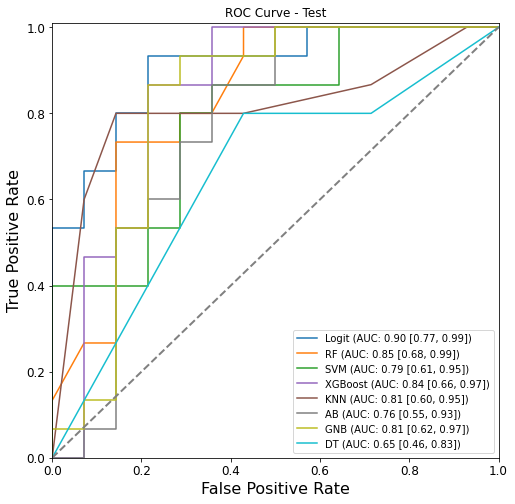

In [73]:


colors = plt.cm.get_cmap('tab10', len(optimized_models))
plt.figure(figsize=(8, 8))
for i, (name, model) in enumerate(optimized_models.items()):
    model.fit(X_train,y_train)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    plt.plot(fpr_test, tpr_test, label=f'{name} (AUC: {results_dict[name]["AUC"][0]:.2f} [{results_dict[name]["AUC"][1][0]:.2f}, {results_dict[name]["AUC"][1][1]:.2f}])', color=colors(i))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.xticks(fontsize=12) 
plt.ylabel('True Positive Rate',fontsize=16)
plt.yticks(fontsize=12) 
plt.title('ROC Curve - Test')
plt.legend()   
plt.savefig('/home/xyy/jupyter/result/AUC.pdf', format='pdf', dpi=300)  

/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_132748/1163409309.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usin

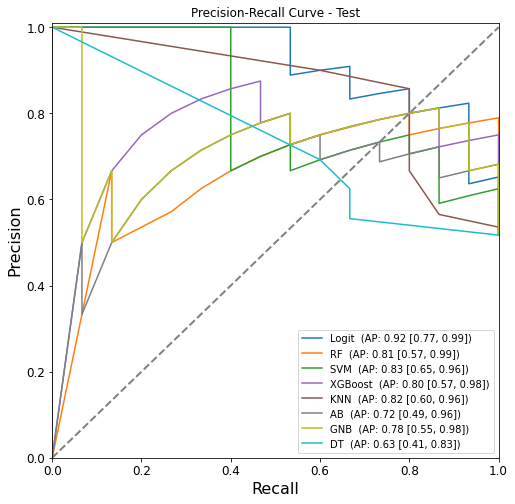

In [72]:
#PR曲线
plt.figure(figsize=(8, 8))
for i, (name, model) in enumerate(optimized_models.items()):
    model.fit(X_train, y_train)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
    plt.plot(recall_test, precision_test, label=f'{name}  (AP: {results_dict[name]["Average Precision (AP)"][0]:.2f} [{results_dict[name]["Average Precision (AP)"][1][0]:.2f}, {results_dict[name]["Average Precision (AP)"][1][1]:.2f}])', color=colors(i))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12) 
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.title('Precision-Recall Curve - Test')
plt.legend()
plt.savefig('/home/xyy/jupyter/result/PR.pdf', format='pdf', dpi=300)

/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_132748/757486852.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using

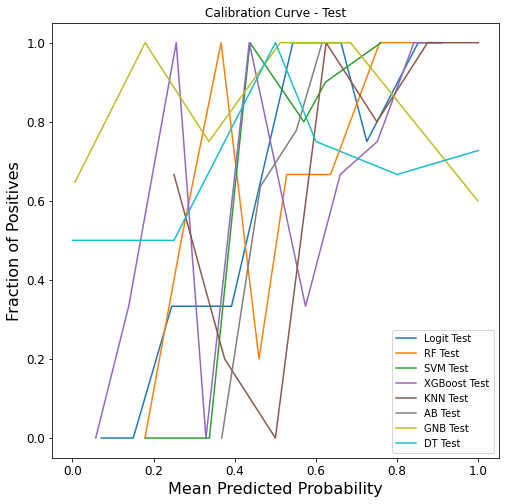

In [101]:
plt.figure(figsize=(8, 8))
for i, (name, model) in enumerate(optimized_models.items()):
        model.fit(X_train, y_train)
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
        prob_true_test, prob_pred_test = calibration_curve(y_test, y_pred_proba_test, n_bins=10)
        plt.plot(prob_pred_test, prob_true_test, label=f'{name} Test', color=colors(i))

# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.01])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)         
plt.xlabel('Mean Predicted Probability',fontsize=16)
plt.ylabel('Fraction of Positives',fontsize=16)
plt.title('Calibration Curve - Test')
plt.legend()
plt.savefig('/home/xyy/jupyter/result/校准.pdf', format='pdf', dpi=300)

In [97]:
def net_benefit(probabilities, y_true, threshold):
    tp = np.sum((probabilities >= threshold) & (y_true == 1))
    fp = np.sum((probabilities >= threshold) & (y_true == 0))
    fn = np.sum((probabilities < threshold) & (y_true == 1))
    tn = np.sum((probabilities < threshold) & (y_true == 0))
        
    prevalence = (tp + fn) / (tp + fp + tn + fn)
    net_benefit = tp / (tp + fp + tn + fn) - (fp / (tp + fp + tn + fn)) * (threshold / (1 - threshold))
    return net_benefit


/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_132748/2301152801.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usin

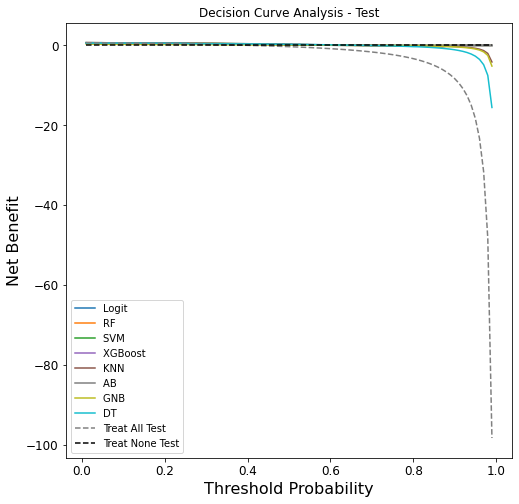

In [100]:
plt.figure(figsize=(8, 8))
thresholds = np.linspace(0.01, 0.99, 99)
for i, (name, model) in enumerate(optimized_models.items()):
    model.fit(X_train, y_train)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    net_benefits_test = [net_benefit(y_pred_proba_test, y_test, threshold) for threshold in thresholds]
    plt.plot(thresholds, net_benefits_test, label=f'{name} ', color=colors(i))
treat_all_test = [np.sum(y_test) / len(y_test) - threshold / (1 - threshold) for threshold in thresholds]
treat_none_test = [0 for _ in thresholds]
plt.plot(thresholds, treat_all_test, linestyle='--', color='gray', label='Treat All Test')
plt.plot(thresholds, treat_none_test, linestyle='--', color='black', label='Treat None Test')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)    
plt.xlabel('Threshold Probability',fontsize=16)
plt.ylabel('Net Benefit',fontsize=16)
plt.title('Decision Curve Analysis - Test')
plt.legend()
plt.savefig('/home/xyy/jupyter/result/校准.pdf', format='pdf', dpi=300)

In [ ]:
type()

pandas.core.frame.DataFrame

/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_132748/3757213164.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/xyy/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usin

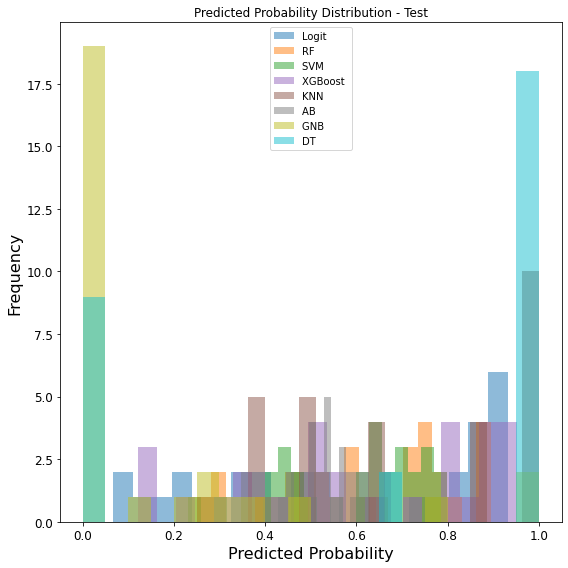

In [84]:
plt.figure(figsize=(8, 8))
for i, (name, model) in enumerate(optimized_models.items()):
    model.fit(X_train, y_train)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_proba_test, bins=20, alpha=0.5, label=f'{name} ', color=colors(i))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)  
plt.xlabel('Predicted Probability',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Predicted Probability Distribution - Test')
plt.legend()
plt.tight_layout()
plt.savefig('/home/xyy/jupyter/result/proba.pdf', format='pdf', dpi=300)
plt.show()